## Загружаем данные

In [ ]:
#решение выполнено в Google Colab

import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#%cd /content/gdrive/My Drive/Colab Notebooks/Computer vision/new course/6

/content/gdrive/My Drive/Colab Notebooks/Computer vision/new course/6


In [ ]:
#!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (1445/1445), done.


In [ ]:
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/Computer vision/new course/6/SegNet-Tutorial/CamVid'

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
#функция для визуализации данных
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize = (16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes = None, 
            augmentation = None, 
            preprocessing = None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
  
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis = -1).astype('float')
        
        # применяем аугментацию
        if self.augmentation:
            sample = self.augmentation(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']
        
        # применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

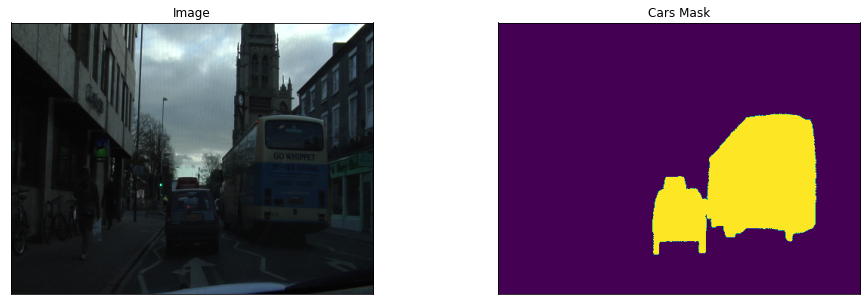

In [ ]:
# посмотрим на данные
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4]

visualize(
    image = image, 
    cars_mask = mask.squeeze(),
)

### Применение аугментации

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p = 0.5),

        albu.ShiftScaleRotate(scale_limit = 0.5, rotate_limit = 0, shift_limit = 0.1, p = 1, border_mode = 0),

        albu.PadIfNeeded(min_height = 320, min_width = 320, always_apply = True, border_mode = 0),
        albu.RandomCrop(height = 320, width = 320, always_apply = True),

        albu.IAAAdditiveGaussianNoise(p = 0.2),
        albu.IAAPerspective(p = 0.5),

        albu.OneOf(
            [
                albu.CLAHE(p = 1),
                albu.RandomBrightness(p = 1),
                albu.RandomGamma(p = 1),
            ],
            p = 0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p = 1),
                albu.Blur(blur_limit = 3, p = 1),
                albu.MotionBlur(blur_limit = 3, p = 1),
            ],
            p = 0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p = 1),
                albu.HueSaturationValue(p = 1),
            ],
            p = 0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    # добавляем пэддинг, чтобы размерность была кратна 32
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    
    _transform = [
        albu.Lambda(image = preprocessing_fn),
        albu.Lambda(image = to_tensor, mask = to_tensor),
    ]
    return albu.Compose(_transform)

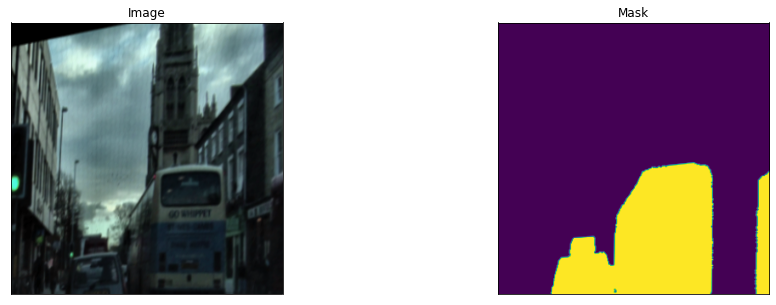

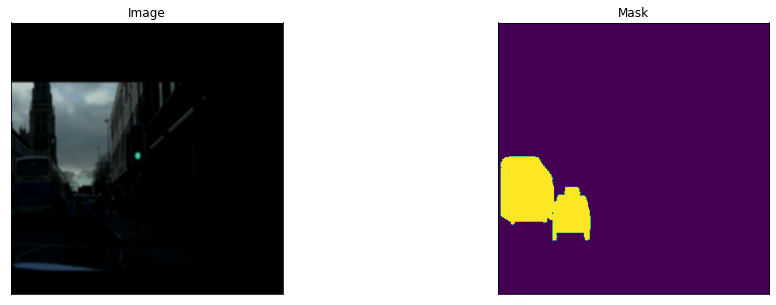

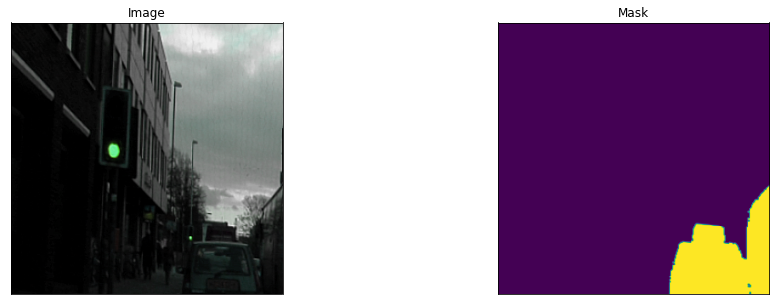

In [ ]:
#### визуализируем изображения после применения аугментации 

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation = get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image = image, mask = mask.squeeze(-1))

## Создаём и обучаем модель

In [ ]:
import torch
import numpy as np
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' 

# создаём модель с предобученной ResNext c 50 слоями
model = smp.FPN(
    encoder_name = ENCODER, 
    encoder_weights = ENCODER_WEIGHTS, 
    classes = len(CLASSES), 
    activation = ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation = get_training_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)

In [ ]:
#в качестве функции потерь используем коэффициент Сёренсена
#для метрики качества используем коэффициент Жаккара

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold = 0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params = model.parameters(), lr = 0.0001),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    optimizer = optimizer,
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    verbose = True,
)

In [ ]:
# обучаем модель на протяжении 40 эпох, лучшую сохраняем

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/Computer vision/new course/6/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [02:03<00:00,  1.22s/it, dice_loss - 0.4142, iou_score - 0.4903]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [02:02<00:00,  1.21s/it, dice_loss - 0.3881, iou_score - 0.5187]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [02:11<00:00,  1.30s/it, dice_loss - 0.2715, iou_score - 0.6425]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [02:10<00:00,  1.30s/it, dice_loss - 0.2753, iou_score - 0.6363]

Epoch: 4
valid: 100%|██████████| 101/101 [01:56<00:00,  1.15s/it, dice_loss - 0.2506, iou_score - 0.6635]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [01:57<00:00,  1.16s/it, dice_loss - 0.242, iou_score - 0.6742]
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [01:59<00:00,  1.18s/it, dice_loss - 0.2965, iou_score - 0.6077]

Epoch: 7
valid: 100%|██████████| 101/101 [01:48<00:00,  1.08s/it, dice_loss - 0.22, iou_score - 0.6975]
Model saved!

Epoch: 8
valid: 100%|██████████| 101/101 [01:53<00:00,  1.12s/it, di

## Проверка лучшей модели на тестовом наборе

In [ ]:
best_model = torch.load('/content/gdrive/My Drive/Colab Notebooks/Computer vision/new course/6/best_model.pth')

In [ ]:
# создаём тестовый набор
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# оценка модели
test_epoch = smp.utils.train.ValidEpoch(
    model = best_model,
    loss = loss,
    metrics = metrics,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [02:57<00:00,  1.32it/s, dice_loss - 0.1849, iou_score - 0.7538]


## Визуализация предсказаний

In [ ]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes = CLASSES,
)

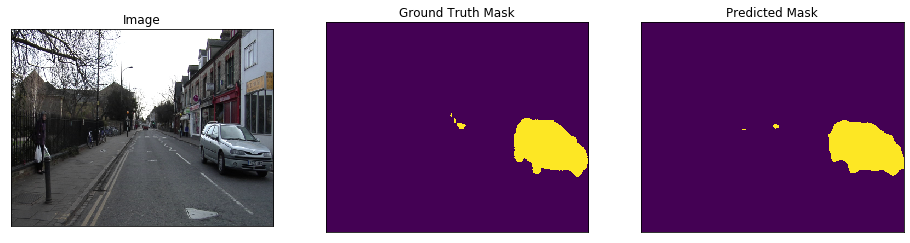

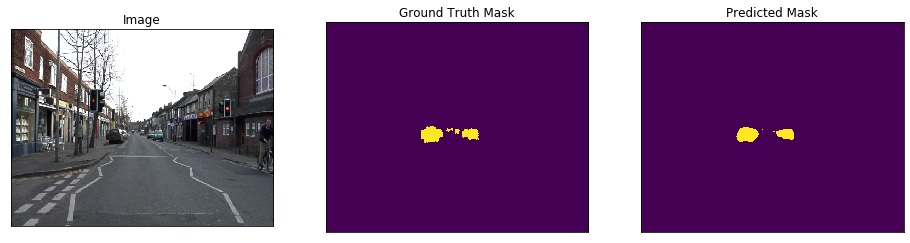

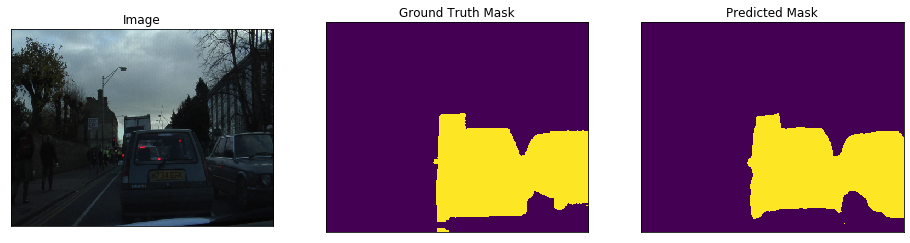

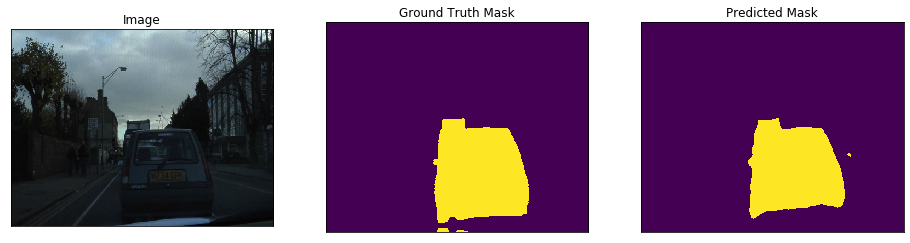

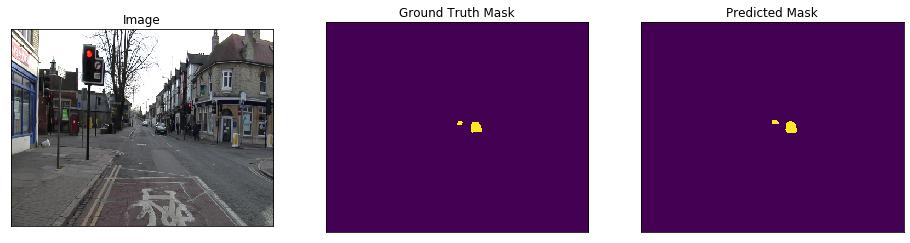

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().numpy().round())
        
    visualize(
        image = image_vis, 
        ground_truth_mask = gt_mask, 
        predicted_mask = pr_mask
    )